In [21]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, Conv2D, Reshape, MultiHeadAttention, LayerNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [22]:
base = '/home/rob/'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  /home/rob/ham10000_data/images/ISIC_0027419.jpg  
1  /home/rob/ham10000_data/images/ISIC_0025030.jpg  
2  /home/rob/ham10000_data/images/ISIC_0026769.jpg  
3  /home/rob/ham10000_data/images/ISIC_0025661.jpg  
4  /home/rob/ham10000_data/images/ISIC_0031633.jpg  


In [23]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(df, df['dx']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

print("Train size: ", len(train_df))
print("Train sizes per label and percentage:")
train_counts = train_df['dx'].value_counts()
train_percentages = (train_counts / len(train_df)) * 100
print(train_counts)
print(train_percentages)

print("\nTest size: ", len(test_df))
print("Test sizes per label and percentage:")
test_counts = test_df['dx'].value_counts()
test_percentages = (test_counts / len(test_df)) * 100
print(test_counts)
print(test_percentages)

Train size:  8012
Train sizes per label and percentage:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       66.949576
mel      11.108337
bkl      10.971043
bcc       5.129805
akiec     3.270095
vasc      1.422866
df        1.148278
Name: count, dtype: float64

Test size:  2003
Test sizes per label and percentage:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
dx
nv       66.949576
mel      11.133300
bkl      10.983525
bcc       5.142287
akiec     3.245132
vasc      1.397903
df        1.148278
Name: count, dtype: float64


In [24]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

class_names = [key for key, _ in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Class Names:", class_names)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Train Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Test Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [25]:
class TransformerBlock(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        norm_inputs = self.layernorm1(inputs) # Added pre-layer normalization
        attn_output = self.att(norm_inputs, norm_inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection


In [26]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

resnet_output = base_model.output

x = Conv2D(256, 1)(resnet_output)  # Project to desired embedding size
x = Reshape((-1, 256))(x)          # Flatten feature maps

transformer_block = TransformerBlock(num_heads=8, key_dim=256, ff_dim=512, dropout=0.1)(x)
x = GlobalAveragePooling1D()(transformer_block)

# Classification head
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [27]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for one-hot encoded multi-class data.

    Parameters:
    - alpha: Weighting factor for positive classes, default is 0.25.
    - gamma: Focusing parameter to reduce the loss contribution from well-classified examples, default is 2.0.

    Returns:
    - A callable loss function for use with Keras models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Compute focal loss components
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow(1 - y_pred, gamma)

        # Compute weighted loss
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed


In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy']
)

In [29]:
model_path = 'models/best_model_resnet50_class_weights_focal_loss.keras'

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', verbose=1)
]

In [30]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=df['dx']
)

class_weights_dict = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print(class_weights_dict)

{0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


In [31]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5553 - loss: 0.2931
Epoch 1: val_loss improved from inf to 0.17350, saving model to models/best_model_resnet50_class_weights_focal_loss.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 570ms/step - accuracy: 0.5555 - loss: 0.2930 - val_accuracy: 0.6699 - val_loss: 0.1735 - learning_rate: 0.0010
Epoch 2/20
  2/250 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.7083 - loss: 0.1172

2024-12-10 09:16:36.846580: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 40 bytes spill stores, 40 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6571 - loss: 0.1992
Epoch 2: val_loss did not improve from 0.17350
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 537ms/step - accuracy: 0.6572 - loss: 0.1992 - val_accuracy: 0.6687 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6653 - loss: 0.1996
Epoch 3: val_loss did not improve from 0.17350
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.6653 - loss: 0.1996 - val_accuracy: 0.6677 - val_loss: 0.1768 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6637 - loss: 0.1916
Epoch 4: val_loss did not improve from 0.17350
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.6637 - loss: 0.1916 - val_accuracy: 0.6707 - val_loss: 0.1771 - learning_rate: 0.0010
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.6706 - loss: 0.1863
Epoch 5: val_loss did not improve from 0.17350
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 51

In [32]:
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(),
    metrics=['accuracy']
)


In [33]:
fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/50
 13/250 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.6589 - loss: 0.2040

2024-12-10 09:58:58.751934: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 40 bytes spill stores, 40 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.6708 - loss: 0.1882
Epoch 1: val_loss did not improve from 0.17129
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 622ms/step - accuracy: 0.6708 - loss: 0.1881 - val_accuracy: 0.6712 - val_loss: 0.1733 - learning_rate: 1.0000e-05
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6992 - loss: 0.1499
Epoch 2: val_loss did not improve from 0.17129
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.6993 - loss: 0.1498 - val_accuracy: 0.6702 - val_loss: 0.1722 - learning_rate: 1.0000e-05
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7494 - loss: 0.1284
Epoch 3: val_loss did not improve from 0.17129
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 524ms/step - accuracy: 0.7494 - loss: 0.1283 - val_accuracy: 0.6677 - val_loss: 0.1833 - learning_rate: 1.0000e-05
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7676 - loss: 0.1200
Epoch 4: val_loss improved from 0.17129 to 0.14780, saving model to mod

In [34]:
model.load_weights(model_path)


In [35]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Total Predictions: {len(test_generator) * BATCH_SIZE}")

/home/rob/.notebook/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.8442 - loss: 0.0547
Test Loss: 0.053254634141922
Test Accuracy: 0.8482276797294617
Total Predictions: 2016


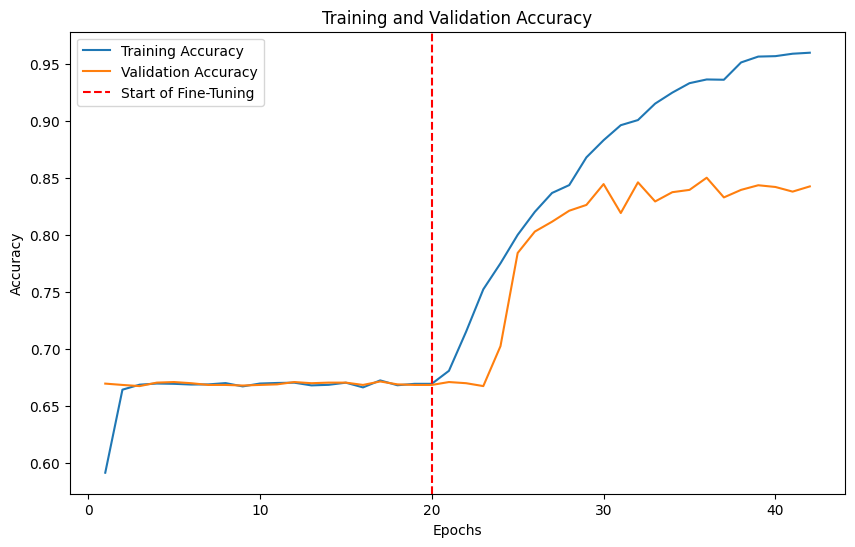

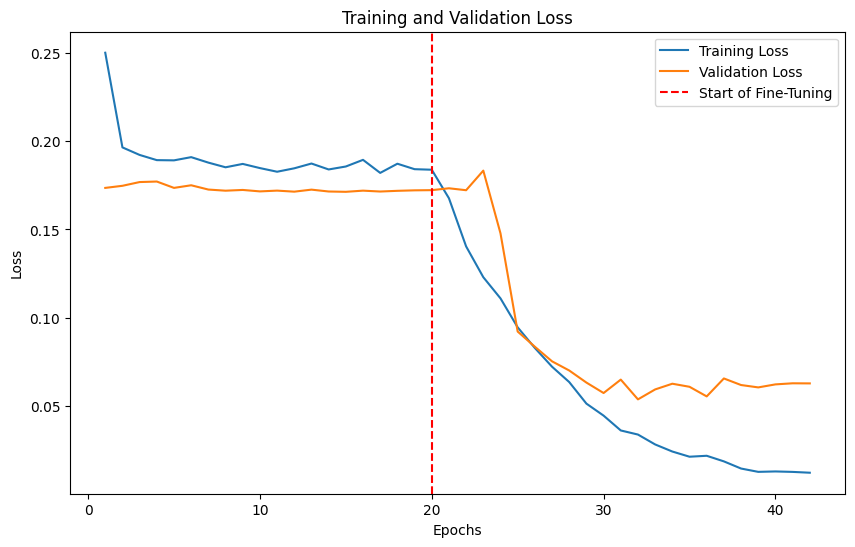

In [36]:
accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [37]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.72      0.58      0.64        65
         bcc       0.84      0.67      0.75       103
         bkl       0.65      0.73      0.69       220
          df       0.56      0.61      0.58        23
         mel       0.63      0.63      0.63       223
          nv       0.93      0.94      0.94      1341
        vasc       0.77      0.61      0.68        28

    accuracy                           0.85      2003
   macro avg       0.73      0.68      0.70      2003
weighted avg       0.85      0.85      0.85      2003



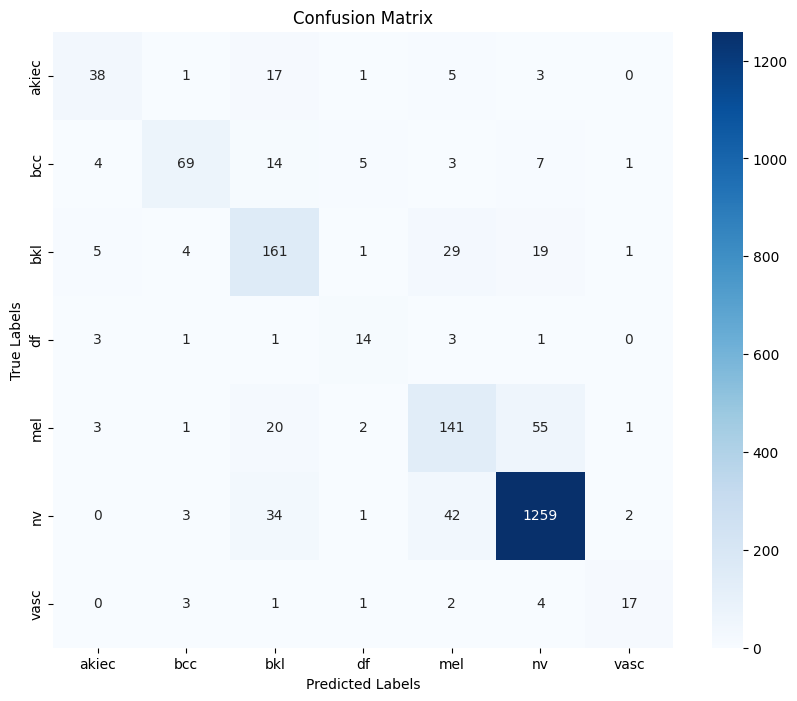

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


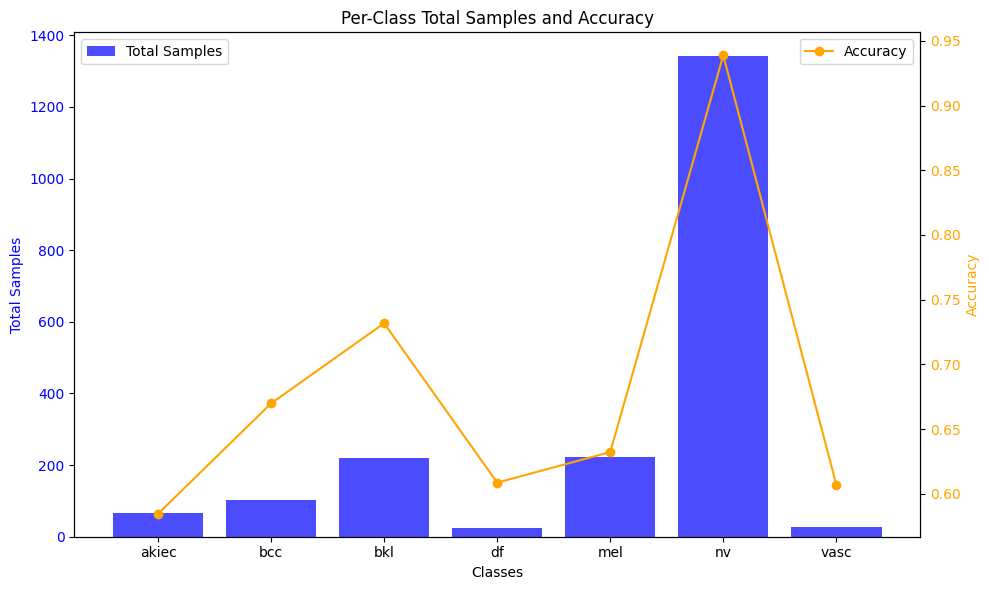

In [39]:
label_counts = np.bincount(y_true)
class_accuracies = np.diag(cm) / label_counts

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
total_counts = label_counts
accuracies = class_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(classes, total_counts, alpha=0.7, label='Total Samples', color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Total Samples', color='blue')
ax1.set_title('Per-Class Total Samples and Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(classes, accuracies, color='orange', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

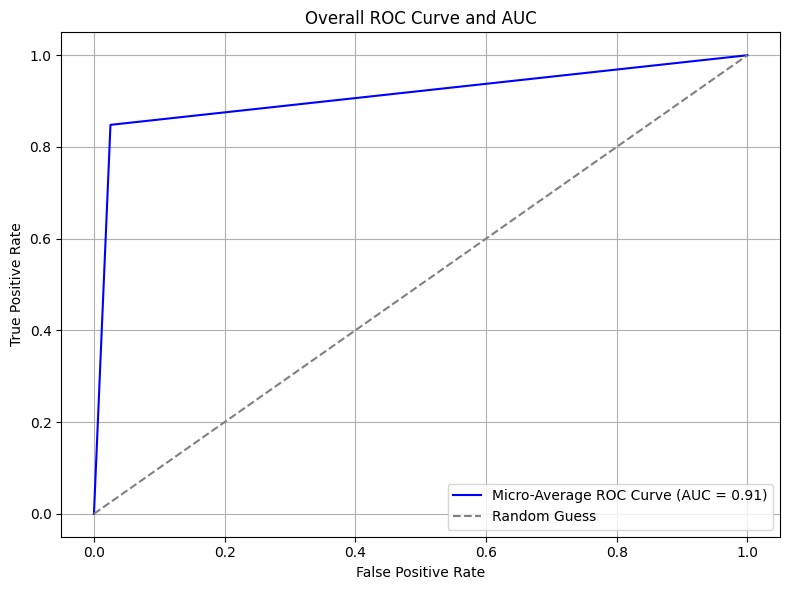

In [40]:
# Compute overall ROC AUC for multi-class classification
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

num_classes = len(classes)
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

y_pred_prob = np.zeros_like(y_true_one_hot)
for i, label in enumerate(y_pred):
    y_pred_prob[i, label] = 1

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Micro-Average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve and AUC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()
